[T355224](https://phabricator.wikimedia.org/T355224)

::: {.callout-warning}

View as HTML
GitHub/GitLab may not render some of the charts properly, [please use the HTML version](https://conniecc1.quarto.pub/wiki-highlights-experment-analysis/).

:::

# Introduction



:::{.callout-note appearance=simple icon=false}

[Wiki Highlights](https://www.mediawiki.org/wiki/Wiki-Highlights) is a concise overview of text generated from the lead and other sections of a Wikipedia article, combined with a relevant image, whose purpose is to highlight relevant facts from a lengthy paragraph.

The experiment ran through January 4th to January 6th in six countries: Brazil, Germany, India, Indonesia, Nigeria, United States. The participants in each country were randomly assigned two versions of content uploaded on microsites: the highlight version of content and the article version of content. The content is sourced from English Wikipedia and Commons, as featured in this list. Participants were able to read one of the versions of content and choose whether to continue reading more or exit the microsite. 

:::

# Purpose <a id="purpose"></a>

:::{.callout-note appearance=simple icon=false}


We are measuring the following set of metrics, to understand whether Wiki-Highlights is a viable reading experience for global youth audiences on 3rd party platform. 

**Primary metric**

- Time on site(session length)
  - Total time = Time on homepage + Time on content page
  - Time on homepage
  - Time on content page

**Secondary metrics**

- Summaries completion rate 
- Number of summaries consumed per session 
- Popular topics 



:::


# Summary

:::{.callout-tip icon=false collapse=false appearance=simple}


- There are more users tend to spend more time viewing highlights than viewing articles. 
- We also noticed that users consumed more highlights in each session. 
- Although we have more highlights opened than articles, users tend to finish reading more articles than highlights. 
- Countries-wise, users in Germany seemed to be more positive about articles. In which there was longer time spent, more content opened and more content completed. While in other countries, like Brazil, India, and Nigeria, users are in favor of highlights. 

:::

# Data Preparation <a id="data"></a>

In [1]:
import matplotlib as mpl
import math
import pandas as pd
import numpy as np
import scipy
from pandasql import sqldf

import wmfdata
from wmfdata import hive, mariadb, spark
 
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
spark_session = wmfdata.spark.create_session(app_name='pyspark regular; wiki-highlights',
                                  type='yarn-regular', # local, yarn-regular, yarn-large
                                         )  

In [5]:
country_list = ('Brazil', 'Germany', 'India', 'Indonesia', 'Nigeria', 'United States')

In [6]:
## Adding function for percentile

def percentile(n):
    def percentile_(x):
        return x.quantile(n)
    percentile_.__name__ = 'percentile_{:02.0f}'.format(n*100)
    return percentile_

## Wiki highlights Event Data

Collect event data from [wiki_highlights_experiment](https://gerrit.wikimedia.org/r/plugins/gitiles/schemas/event/secondary/+/refs/heads/master/jsonschema/analytics/external/wiki_highlights_experiment/1.0.0.yaml) schema between the test period January 4th - January 16th. 

In [7]:
event_data_query = """

SELECT
  meta.dt as server_dt,
  experiment_group,
  geocoded_data['country'] as user_country,
  md5(concat(http.client_ip, '+{salt}')) as ip_hash,
  session_id, event_type,
  page_name, 
  CASE WHEN page_name IN ('categories_highlights', 'categories_articles') THEN 'homepage' ELSE topic END AS topic, -- hard code homepage
  CASE WHEN page_name IN ('categories_highlights', 'categories_articles') THEN 'homepage' ELSE category_name END AS category_name, -- hard code homepage
  page_bottom_was_visible, time_length_ms
FROM event.inuka_wiki_highlights_experiment e
LEFT JOIN cchen.wiki_highlights_article_list l ON e.page_name = l.article_title
WHERE
   (year = 2024 AND month = 1 AND day >=4 AND day <= 16)

"""

In [ ]:
event_data = spark.run(event_data_query)

In [ ]:
# store data in GlobalTempView
event_sdf = spark_session.createDataFrame(event_data)
event_sdf.createGlobalTempView("event_data_view")

# Metrics <a id="metrics"></a>

## Time on Site (Session Length) <a id="time"></a>

The metric indicates users' willingness to consume articles and highlights. All the times we calculate are in seconds.

In [10]:
time_on_site_query = """ 
 
 SELECT 
        experiment_group,
        session_id,
        SUM(time_length_ms)/1000 AS total_length,
        SUM(CASE WHEN topic = 'homepage' THEN time_length_ms END)/1000 AS home_length,
        SUM(CASE WHEN topic != 'homepage' THEN time_length_ms END)/1000 AS content_length
    FROM global_temp.event_data_view
    WHERE event_type = 'pageUnloaded'
    GROUP BY experiment_group, session_id
    
"""


In [ ]:
time_on_site = spark.run(time_on_site_query)

In [12]:
## Check % of sessions with only homepage visits, no content page visits
sqldf("""
    
    SELECT 
        experiment_group,
        SUM(CASE WHEN content_length IS NULL THEN 1 END)*100 /  COUNT(1) AS hp_only_pct
    FROM time_on_site
    GROUP BY experiment_group
    
""")

experiment_group  hp_only_pct
0          control           51
1       experiment           52

:::{.callout-note appearance=simple icon=false}

There were 51% and 52% of sessions with only homepage visits in the control group and the experiment group, respectively.

:::

### Total Time <a id="total_time"></a>

In [13]:
time_grouped = time_on_site.groupby('experiment_group')
total_time_column = time_grouped['total_length']

In [14]:
total_time_column.agg([percentile(0.5), percentile(0.75), percentile(0.90), percentile(0.95)])

percentile_50  percentile_75  percentile_90  percentile_95
experiment_group                                                            
control                  18.942         41.227        95.2176       188.6705
experiment               20.524         46.332       109.9998       197.8194

/tmp/ipykernel_3136929/331582030.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(data=time_on_site, x="total_length", hue="experiment_group", shade=True, log_scale=True, clip =(-1,3.5))
/tmp/ipykernel_3136929/331582030.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set(xticklabels=[0,0,0,1,10,100,1000])


Text(0.5, 1.0, 'Total Time Spent')

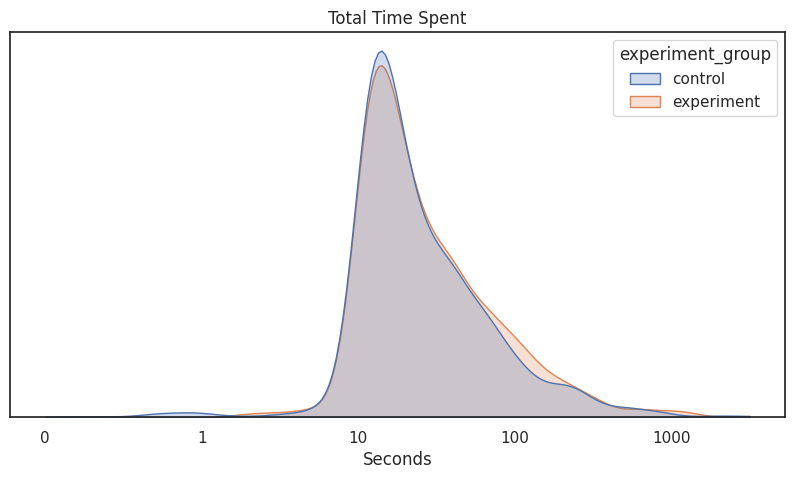

In [40]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(10,5))

fig = sns.kdeplot(data=time_on_site, x="total_length", hue="experiment_group", shade=True, log_scale=True, clip =(-1,3.5))
fig.set(yticklabels=[]) 
fig.set(ylabel=None)
fig.set(xticklabels=[0,0,0,1,10,100,1000]) 

plt.xlabel("Seconds")
plt.title('Total Time Spent')

Text(0.5, 1.0, 'Total Time Spent')

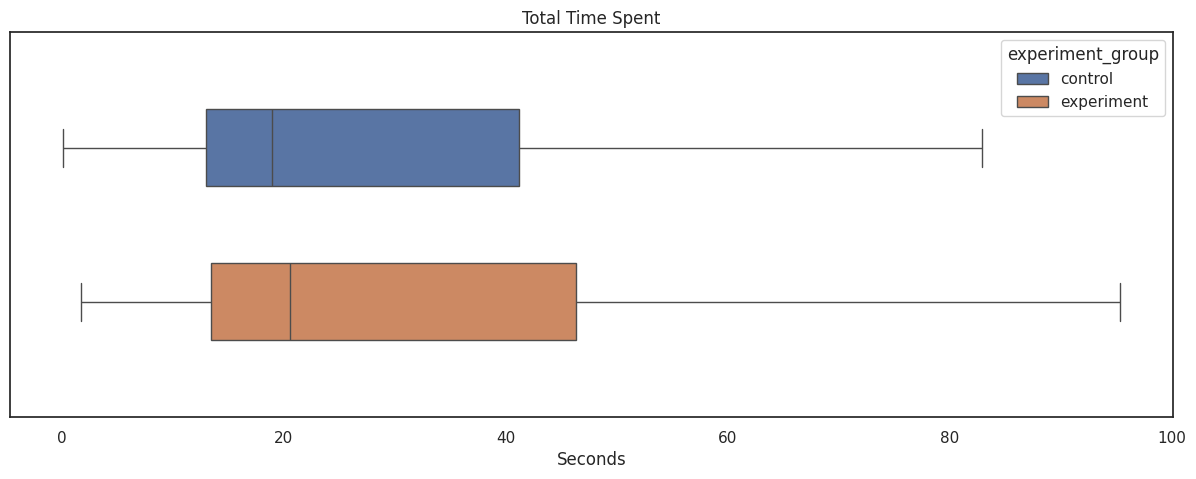

In [28]:
sns.set(rc={'figure.figsize':(15,5)})
sns.set_style("white")

sns.boxplot(data=time_on_site, x="total_length", hue="experiment_group",showfliers=False, gap=.5)

plt.xlabel("Seconds")
plt.title('Total Time Spent')


:::{.callout-note appearance=simple icon=false}

In control group, 50% of sessions had a total reading time between 0 to 19 seconds; and in experiment group, 50% of sessions had a total reading time between 0 to 21 seconds. 

In control group, 95% of sessions had a total reading time between 0 to 189 seconds; and in experiment group, 95% of sessions had a total reading time between 0 to 198 seconds.

The **experiment group** had more users spent more time on homepages and content pages than the **control group**. 

:::

### Time on Homepage <a id="homepage_time"></a>

In [24]:
home_time_column = time_grouped['home_length']
home_time_column.agg([percentile(0.5), percentile(0.75), percentile(0.90), percentile(0.95)])

percentile_50  percentile_75  percentile_90  percentile_95
experiment_group                                                            
control                  14.348       27.75075        51.5783       76.13905
experiment               14.877       27.59550        52.5068       78.76800

/tmp/ipykernel_3136929/3455724706.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(data=time_on_site, x="home_length", hue="experiment_group", shade=True, log_scale=True, clip =(-1,3.5))
/tmp/ipykernel_3136929/3455724706.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set(xticklabels=[0,0,0,1,10,100,1000])


Text(0.5, 1.0, 'Homepage Time Spent')

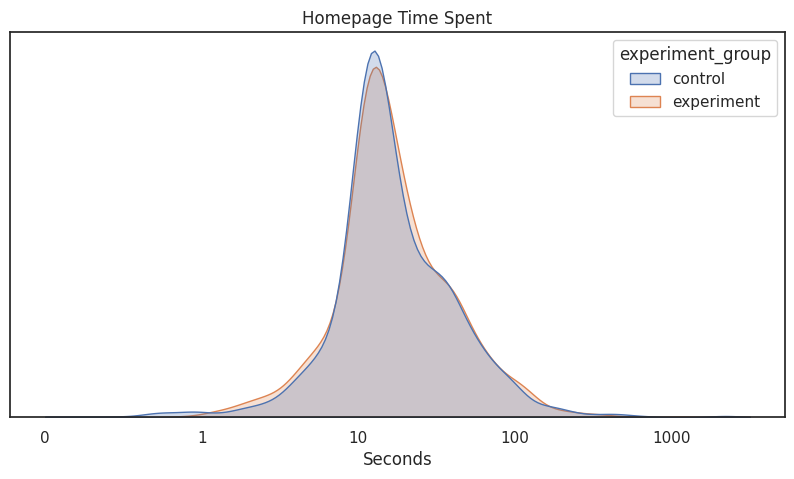

In [38]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(10,5))

fig = sns.kdeplot(data=time_on_site, x="home_length", hue="experiment_group", shade=True, log_scale=True, clip =(-1,3.5))
fig.set(yticklabels=[]) 
fig.set(ylabel=None)
fig.set(xticklabels=[0,0,0,1,10,100,1000]) 

plt.xlabel("Seconds")
plt.title("Homepage Time Spent")

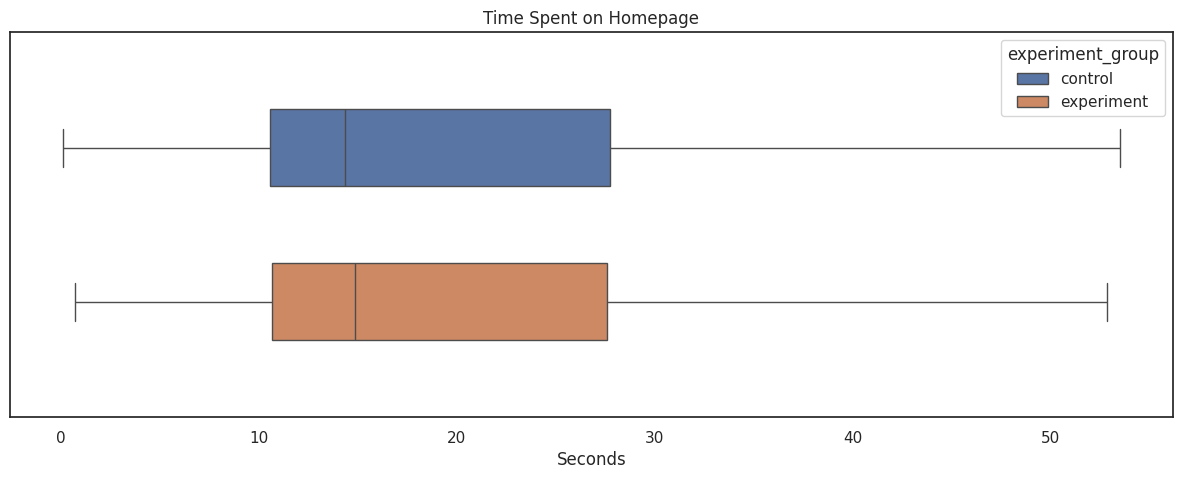

In [27]:
sns.boxplot(data=time_on_site, x="home_length", hue="experiment_group",showfliers=False, gap=.5)

plt.xlabel("Seconds")
plt.title('Time Spent on Homepage')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

:::{.callout-note appearance=simple icon=false}


In control group, 50% of sessions had a total reading time between 0 to 14 seconds; and in experiment group, 50% of sessions had a total reading time between 0 to 15 seconds.

In control group, 95% of sessions had a total reading time between 0 to 76 seconds; and in experiment group, 95% of sessions had a total reading time between 0 to 79 seconds.

The users in the **experiment group** seem to stay at a similar time as the users in the **control group** on the home page.

:::

### Time on Content Page <a id="content_time"></a>

In [29]:
content_time_column = time_grouped['content_length']
content_time_column.agg([percentile(0.5), percentile(0.75), percentile(0.90), percentile(0.95)])

percentile_50  percentile_75  percentile_90  percentile_95
experiment_group                                                            
control                   9.698       29.08675       116.2183       214.5830
experiment               11.725       46.27050       129.4230       260.2247

/tmp/ipykernel_3136929/2061442196.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(data=time_on_site, x="content_length", hue="experiment_group", shade=True, log_scale=True, clip =(-1,3.5))
/tmp/ipykernel_3136929/2061442196.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  fig.set(xticklabels=[0,0,0,1,10,100,1000])


Text(0.5, 1.0, 'Contnt Time Spent')

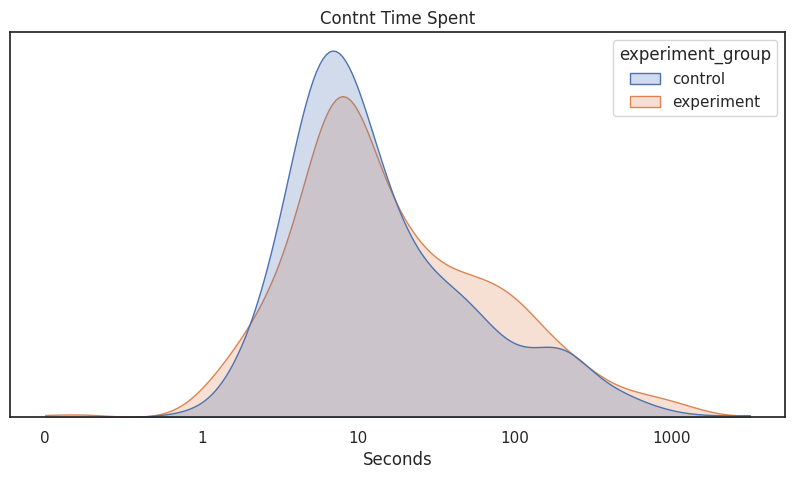

In [41]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(10,5))

fig = sns.kdeplot(data=time_on_site, x="content_length", hue="experiment_group", shade=True, log_scale=True, clip =(-1,3.5))
fig.set(yticklabels=[]) 
fig.set(ylabel=None)
fig.set(xticklabels=[0,0,0,1,10,100,1000]) 

plt.xlabel("Seconds")
plt.title("Contnt Time Spent")

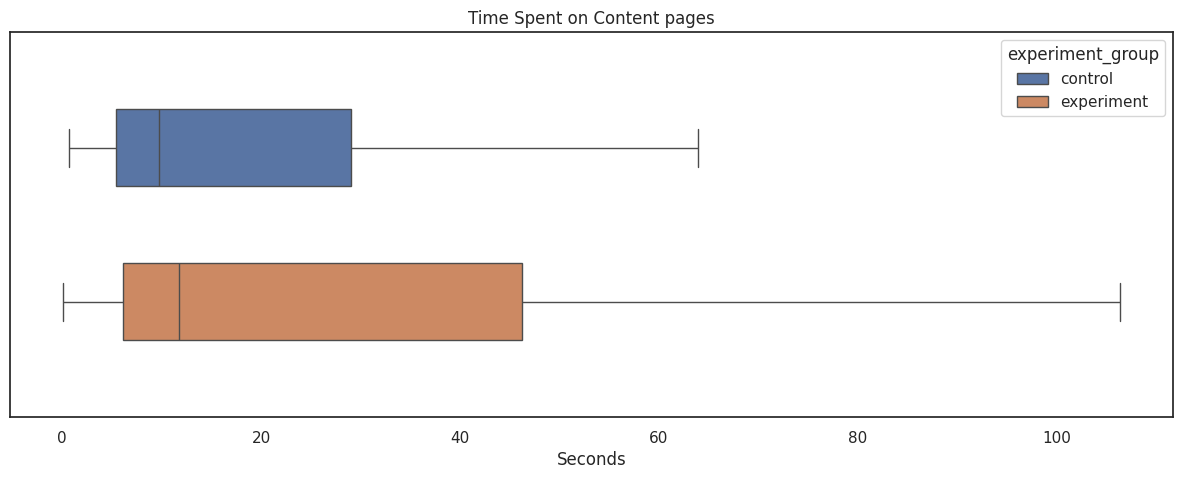

In [42]:
sns.boxplot(data=time_on_site, x="content_length", hue="experiment_group",showfliers=False, gap=.5)

plt.xlabel("Seconds")
plt.title('Time Spent on Content pages')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

:::{.callout-note appearance=simple icon=false}


In control group, 50% of sessions had a total reading time between 0 to 10 seconds; and in experiment group, 50% of sessions had a total reading time between 0 to 12 seconds.

In control group, 95% of sessions had a total reading time between 0 to 215 seconds; and in experiment group, 95% of sessions had a total reading time between 0 to 260 seconds.

For number of users who viewed content pages, the **experiment group** had more users spent more time on content pages than the **control group**.

:::

:::{.callout-note collapse=false}

In the control group, the articles are collapsed. This implies that it might be possible that some users did not expand each section to read through the entire article; which could have potentially affected the reading time of in control group

:::

## Content Read Completion Rate <a id="content_complete"></a>

The metric indicates users' willingness to complete reading the content. Content is considered complete when users reach the bottom of an article or the last page of a highlight.

When calculating the completion rate, we are excluding homepage visits. 

In [19]:
content_completion_query = """

SELECT 
    experiment_group AS ExperimentGroup,
    COUNT(1) AS Pageview,
    SUM(CASE WHEN page_bottom_was_visible THEN 1 END)/ COUNT(1) AS CompletionRate
FROM global_temp.event_data_view
WHERE event_type = 'pageUnloaded'
      AND topic != 'homepage'
GROUP BY experiment_group
    
"""

In [ ]:
content_completion = spark.run(content_completion_query)

In [ ]:
content_completion

ExperimentGroup  Pageview  CompletionRate
0         control      1112        0.781475
1      experiment      1658        0.721954

:::{.callout-note appearance=simple icon=false}

The control group had 1,112 articles opened, with a 78.1% completion rate. 

The experiment group had more highlights read but less completion rate. There are 1,658 highlights opened with a 72.2% completion rate. 

:::

## Number of Content Viewed per Session <a id="content_per_session"></a>

The metric reflects users' willingness to view subsequent highlights and articles. 

We also exclude homepage views here. If a session only had homepage views, then we count it as 0 content views in that session

In [ ]:
content_per_session_query = """

SELECT
    experiment_group,
    session_id, 
    SUM(CASE WHEN topic = 'homepage' THEN 0 ELSE 1 END) AS num_pages
FROM global_temp.event_data_view
WHERE event_type = 'pageUnloaded'
GROUP BY experiment_group,session_id

"""

In [ ]:
content_per_session = spark.run(content_per_session_query)

In [ ]:
content_per_session_grouped = content_per_session.groupby('experiment_group')
content_per_session_column = content_per_session_grouped['num_pages']

In [49]:
content_per_session_column.agg([percentile(0.5), percentile(0.75), percentile(0.90), percentile(0.95)])

percentile_50  percentile_75  percentile_90  percentile_95
experiment_group                                                            
control                     0.0            1.0            2.0            3.0
experiment                  0.0            1.0            3.0            4.0

/tmp/ipykernel_3136929/3845779504.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  fig = sns.kdeplot(data=content_per_session, x="num_pages", hue="experiment_group", shade=True, cut =0, clip=(0,15),


Text(0.5, 1.0, 'Number of Content per Session')

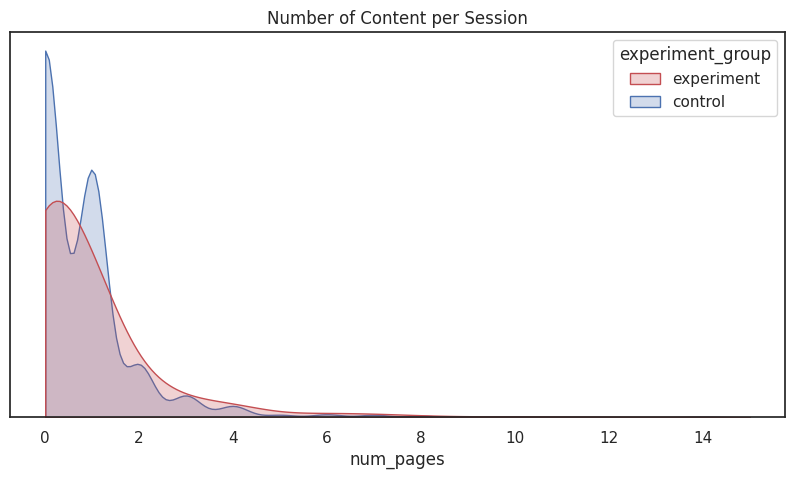

In [56]:
sns.set_style("white")
fig, ax = plt.subplots(figsize=(10,5))

fig = sns.kdeplot(data=content_per_session, x="num_pages", hue="experiment_group", shade=True, cut =0, clip=(0,15),
                 palette={'control':'b', 'experiment':'r'})
fig.set(yticklabels=[]) 
fig.set(ylabel=None)

plt.title("Number of Content per Session")

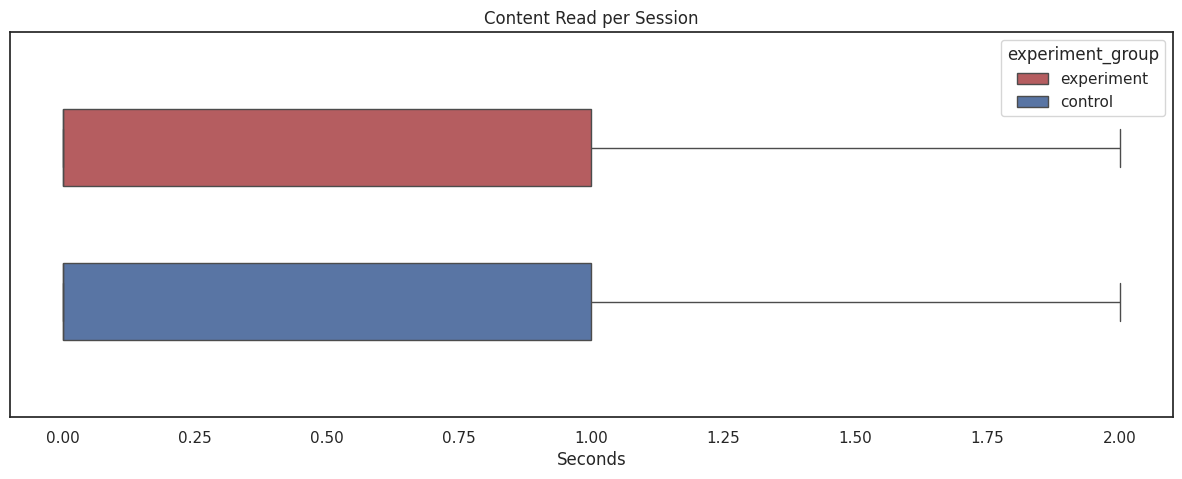

In [58]:
sns.boxplot(data=content_per_session, x="num_pages", hue="experiment_group",showfliers=False, gap=.5,
           palette={'control':'b', 'experiment':'r'})

plt.xlabel("Seconds")
plt.title("Content Read per Session")

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

:::{.callout-note appearance=simple icon=false}


There were 50% of sessions with 0 summary/article consumed per session for both control and experiment groups. 

There were 75% of sessions with 0 or 1 summaries/articles consumed per session for both control and experiment groups.

For the **control group**, there were 95% of sessions with 0 to 3 articles per session. 
For the **experiment group**, there were 95% of sessions with 0 to 4 summaries per session. 

There are more users in **experiment group** viewed slightly more summaries in **control group** does. 

:::

## Top Viewed Content <a id="top_content"></a>

This section shows which topics & categories had majority of reads through pageviews/wiki highlights views. Additionally, we include the content completion rate as a reference.

For the list of featured articles and their topics, please refer to [this sheet](https://docs.google.com/spreadsheets/d/1QQmU6TmXUyrJc2K_9mMlRN_TK2Jt3U9GCVupMUKPgsI/edit#gid=611358363). 


In [27]:
top_page_query = """

    SELECT 
        experiment_group AS ExperimentGroup,
        page_name AS Page, 
        COUNT(1) AS Pageview,
        SUM(CASE WHEN page_bottom_was_visible THEN 1 ELSE 0 END)/ COUNT(1) AS CompletionRate
    FROM global_temp.event_data_view
    WHERE event_type = 'pageUnloaded'
      AND topic != 'homepage'
    GROUP BY experiment_group, page_name

"""


In [ ]:
top_page = spark.run(top_page_query)

Top 10 viewed articles in contol group are: 

In [30]:
top_page.loc[(top_page['ExperimentGroup'] == 'control')].sort_values(by=['Pageview'], ascending=False).head(10)

ExperimentGroup               Page  Pageview  CompletionRate
49         control       Lionel Messi        76        0.881579
6          control            Friends        62        0.806452
16         control              Japan        60        0.783333
34         control      Ancient Egypt        53        0.735849
55         control      Body piercing        47        0.808511
40         control           Baseball        46        0.695652
20         control             Comics        46        0.847826
17         control           Feminism        43        0.813953
31         control            Obesity        42        0.833333
37         control  Statue of Liberty        41        0.804878

Top 10 viewed highligths in experiment group are: 

In [31]:
top_page.loc[(top_page['ExperimentGroup'] == 'experiment')].sort_values(by=['Pageview'], ascending=False).head(10)

ExperimentGroup                Page  Pageview  CompletionRate
14      experiment        Lionel Messi        99        0.595960
45      experiment      Climate change        86        0.767442
52      experiment            Elephant        80        0.700000
11      experiment               Japan        79        0.721519
26      experiment             Friends        74        0.756757
38      experiment             Obesity        71        0.760563
39      experiment              Comics        69        0.710145
28      experiment  Sustainable energy        69        0.695652
29      experiment   Statue of Liberty        64        0.593750
44      experiment                Yoga        62        0.693548

## Top Viewed Topics <a id="top_topic"></a>

In [32]:
top_topic_query = """

    SELECT 
        experiment_group AS ExperimentGroup,
        category_name AS Topic, 
        COUNT(1) AS Pageview,
        SUM(CASE WHEN page_bottom_was_visible THEN 1 ELSE 0 END)/ COUNT(1) AS CompletionRate
    FROM global_temp.event_data_view
    WHERE event_type = 'pageUnloaded'
      AND topic != 'homepage'
    GROUP BY experiment_group, category_name

"""

In [ ]:
top_topic = spark.run(top_topic_query)

Top viewed topics in contol group are:

In [34]:
top_topic.loc[(top_topic['ExperimentGroup'] == 'control')].sort_values(by=['Pageview'], ascending=False).head(10)

ExperimentGroup          Topic  Pageview  CompletionRate
8          control      LIFESTYLE       190        0.800000
0          control  PERSONALITIES       184        0.836957
6          control        HISTORY       160        0.787500
4          control        TOPICAL       150        0.820000
5          control          SPORT       146        0.705479
10         control         NATURE       145        0.710345
2          control         PLACES       137        0.788321

Top viewed topics in experiment group are:

In [35]:
top_topic.loc[(top_topic['ExperimentGroup'] == 'experiment')].sort_values(by=['Pageview'], ascending=False).head(10)

ExperimentGroup          Topic  Pageview  CompletionRate
12      experiment        TOPICAL       286        0.762238
3       experiment  PERSONALITIES       257        0.680934
11      experiment         NATURE       254        0.728346
1       experiment      LIFESTYLE       245        0.767347
7       experiment         PLACES       216        0.726852
13      experiment          SPORT       207        0.719807
9       experiment        HISTORY       193        0.647668

:::{.callout-note appearance=simple icon=false}

Nature didn’t show up at the top for any country contrary to user feedback from the survey.

:::


# Metrics Breakdown by Countries <a id="metrics_c"></a>

Add a country-wise breakdown for each metric to facilitate comparisons.

## Time on Site (Session Length) <a id="time_c"></a>

In [61]:
time_on_site_c_query = """ 
 
 SELECT 
        user_country,
        experiment_group,
        session_id,
        SUM(time_length_ms)/1000 AS total_length,
        SUM(CASE WHEN topic = 'homepage' THEN time_length_ms END)/1000 AS home_length,
        SUM(CASE WHEN topic != 'homepage' THEN time_length_ms END)/1000 AS content_length
    FROM global_temp.event_data_view
    WHERE event_type = 'pageUnloaded'
      AND user_country IN {country_list}   
    GROUP BY user_country,experiment_group, session_id
    
"""

In [62]:
time_on_site_c = spark.run(
       time_on_site_c_query.format(
          country_list = country_list
        ))

### Total Time <a id="total_time_c"></a>

In [36]:
totla_time_c_query= """

    WITH total_time AS (
        SELECT 
            user_country,
            experiment_group,
            session_id,
            SUM(time_length_ms)/1000 AS total_length
        FROM global_temp.event_data_view
        WHERE event_type = 'pageUnloaded'
          AND user_country IN {country_list}   
        GROUP BY user_country,experiment_group, session_id
    )
    
    SELECT
       user_country AS Country,
       experiment_group AS ExperimentGroup,
       PERCENTILE_APPROX(total_length,0.50) AS 50_percentile,
       PERCENTILE_APPROX(total_length,0.75) AS 75_percentile,
       PERCENTILE_APPROX(total_length,0.90) AS 90_percentile,
       PERCENTILE_APPROX(total_length,0.95) AS 95_percentile
    FROM total_time
    GROUP BY user_country,experiment_group
    ORDER BY user_country,experiment_group

"""

In [37]:
spark.run( 
         totla_time_c_query.format(
          country_list = country_list
        )
    )

Country ExperimentGroup  50_percentile  75_percentile  \
0          Brazil         control         20.637         39.948   
1          Brazil      experiment         25.193         52.807   
2         Germany         control         15.257         26.127   
3         Germany      experiment         15.560         24.174   
4           India         control         18.850         36.875   
5           India      experiment         22.300         45.418   
6       Indonesia         control         17.296         28.746   
7       Indonesia      experiment         15.608         25.449   
8         Nigeria         control         42.690        114.206   
9         Nigeria      experiment         60.662        122.915   
10  United States         control         17.650         39.494   
11  United States      experiment         19.837         42.082   

    90_percentile  95_percentile  
0          96.972        164.477  
1         123.295        200.400  
2          49.417         73.394  
3          48.615         68.727  
4          66.654        106.661  
5          92.987        129.510  
6          58.731         76.430  
7          48.345        102.256  
8         297.555        521.008  
9         319.056        606.709  
10         78.332        146.681  
11         88.832        123.535

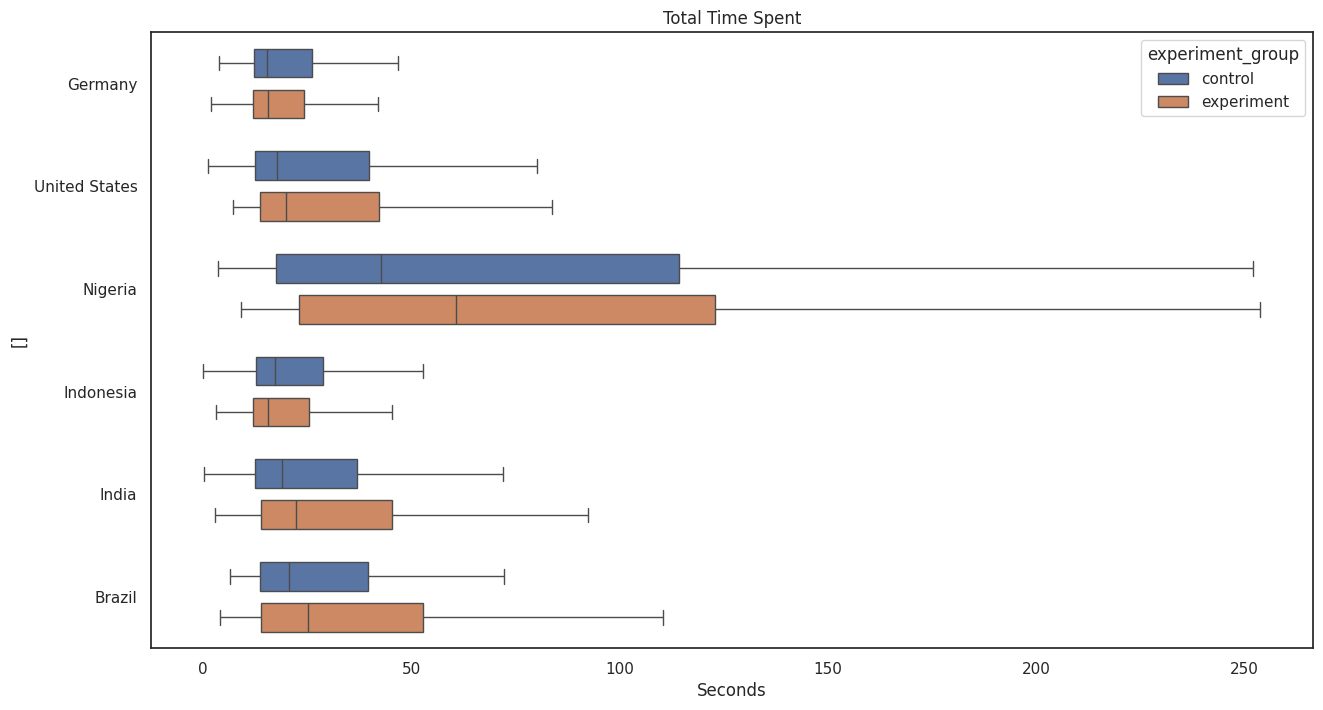

In [87]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style("white")

sns.boxplot(data=time_on_site_c, x="total_length", y = "user_country",hue="experiment_group",showfliers=False, gap=.3)

plt.xlabel("Seconds")
plt.title('Total Time Spent')
plt.ylabel([])  

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

:::{.callout-note appearance=simple icon=false}

From the data above, we discover that, in **Brazil, India, United Stats and Nigeria**, the **experiment group** had more users spent more time on homepages and content pages.

In **Indonesia and Germany**, the **control group** had more users spent more time on homepages and content pages.

:::

### Time on homepage <a id="homepage_time_c"></a>

In [38]:
homepage_c_query= """

    WITH total_time AS (
        SELECT 
            user_country ,
            experiment_group,
            session_id,
            SUM(CASE WHEN topic = 'homepage' THEN time_length_ms END)/1000 AS home_length
        FROM global_temp.event_data_view
        WHERE event_type = 'pageUnloaded'
          AND user_country IN {country_list}   
        GROUP BY user_country,experiment_group, session_id
    )
    
    SELECT
       user_country AS Country,
       experiment_group AS ExperimentGroup,
       PERCENTILE_APPROX(home_length,0.50) AS 50_percentile,
       PERCENTILE_APPROX(home_length,0.75) AS 75_percentile,
       PERCENTILE_APPROX(home_length,0.90) AS 90_percentile,
       PERCENTILE_APPROX(home_length,0.95) AS 95_percentile
    FROM total_time
    GROUP BY user_country,experiment_group
    ORDER BY user_country,experiment_group

"""

In [39]:
spark.run( 
         homepage_c_query.format(
          country_list = country_list
        )
    )

Country ExperimentGroup  50_percentile  75_percentile  \
0          Brazil         control         16.276         32.965   
1          Brazil      experiment         17.559         37.829   
2         Germany         control         12.864         18.631   
3         Germany      experiment         12.830         18.216   
4           India         control         14.632         26.862   
5           India      experiment         15.706         30.874   
6       Indonesia         control         13.864         22.128   
7       Indonesia      experiment         13.366         19.215   
8         Nigeria         control         20.399         50.511   
9         Nigeria      experiment         21.995         53.847   
10  United States         control         13.311         25.069   
11  United States      experiment         13.295         22.200   

    90_percentile  95_percentile  
0          62.115         89.921  
1          77.639        109.329  
2          35.523         42.511  
3          31.342         41.777  
4          43.337         61.269  
5          48.493         81.931  
6          39.994         57.322  
7          37.140         46.788  
8          96.485        178.650  
9          76.100        109.041  
10         40.706         62.318  
11         35.865         48.751

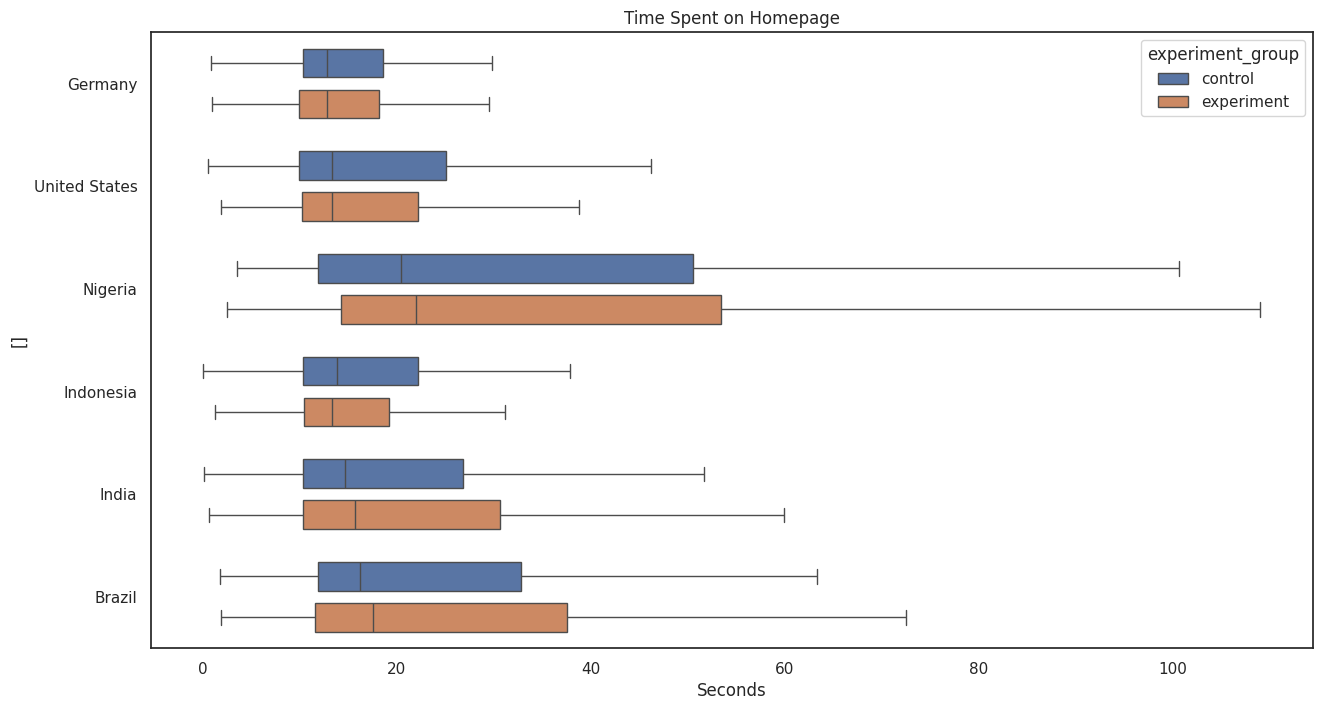

In [88]:
sns.boxplot(data=time_on_site_c, x="home_length", y = "user_country",hue="experiment_group",showfliers=False, gap=.3)
sns.set_style("white")

plt.xlabel("Seconds")
plt.title('Time Spent on Homepage')
plt.ylabel([])  

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

:::{.callout-note appearance=simple icon=false}

For home page time spent, we discover that, in **Brazil, Nigeria, and India**, the **experiment group** had more users spent more time on homepages.

In **Germany**, users spent similar time on homepages pages in the experiment group and control group. 

While in **Indonesia and United States**, the **control group** had more users spent more time on homepages pages.

:::

### Time on content page <a id="content_time_c"></a>

In [40]:
content_time_c_query= """

    WITH total_time AS (
        SELECT 
            user_country,
            experiment_group,
            session_id,
            SUM(CASE WHEN topic != 'homepage' THEN time_length_ms END)/1000 AS content_length
        FROM global_temp.event_data_view
        WHERE event_type = 'pageUnloaded'
          AND user_country IN {country_list}   
        GROUP BY user_country,experiment_group, session_id
    )
    
    SELECT
       user_country AS Country,
       experiment_group AS ExperimentGroup,
       PERCENTILE_APPROX(content_length,0.50) AS 50_percentile,
       PERCENTILE_APPROX(content_length,0.75) AS 75_percentile,
       PERCENTILE_APPROX(content_length,0.90) AS 90_percentile,
       PERCENTILE_APPROX(content_length,0.95) AS 95_percentile
    FROM total_time
    GROUP BY user_country,experiment_group
    ORDER BY user_country,experiment_group

"""

In [41]:
spark.run( 
         content_time_c_query.format(
          country_list = country_list
        )
    )

Country ExperimentGroup  50_percentile  75_percentile  \
0          Brazil         control          8.350         21.339   
1          Brazil      experiment         14.708         41.528   
2         Germany         control          6.515         13.817   
3         Germany      experiment          7.157         11.233   
4           India         control          9.637         20.231   
5           India      experiment         11.766         35.500   
6       Indonesia         control          8.790         17.016   
7       Indonesia      experiment          8.918         19.751   
8         Nigeria         control         43.949        176.100   
9         Nigeria      experiment         79.387        225.900   
10  United States         control          8.436         22.734   
11  United States      experiment         12.308         41.031   

    90_percentile  95_percentile  
0          84.189        203.409  
1         138.720        176.157  
2          37.952         50.856  
3          26.987         57.811  
4          59.604        121.616  
5          92.876        127.866  
6          38.026         70.835  
7         104.614        187.773  
8         369.269        526.803  
9         572.007        969.253  
10         85.557        136.388  
11         85.045        117.422

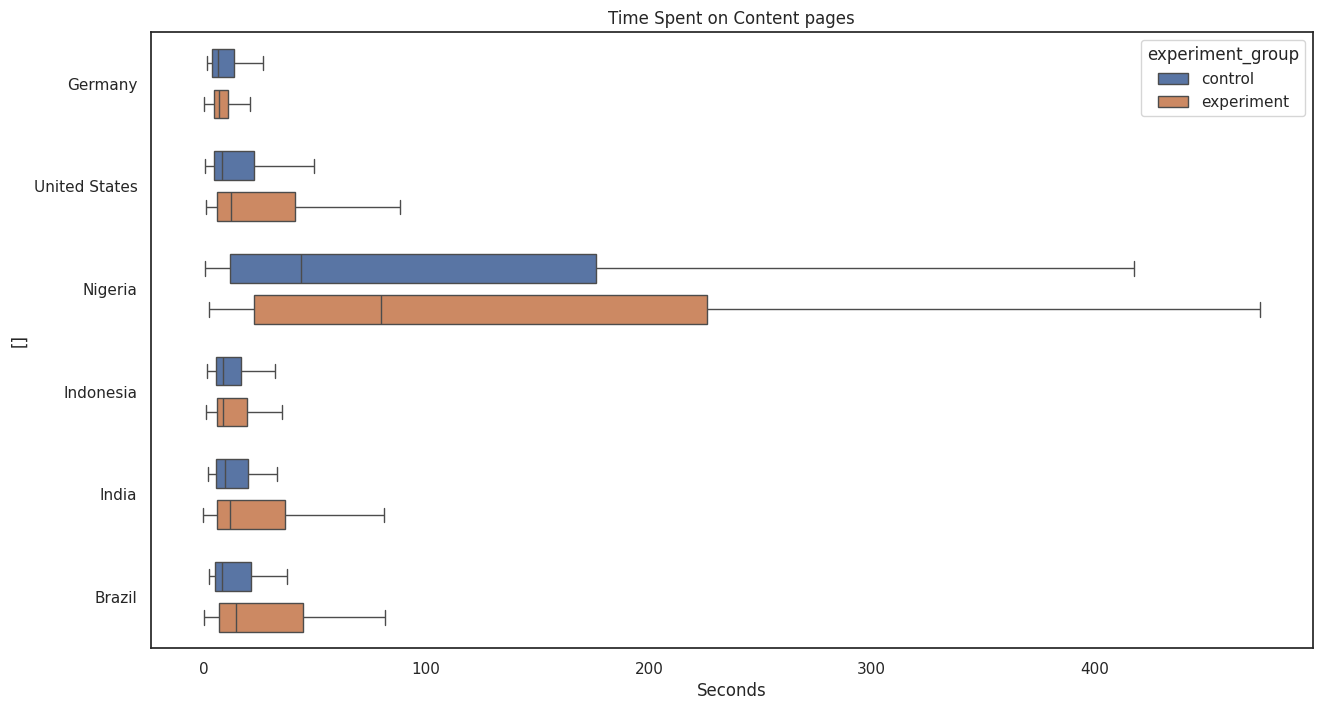

In [89]:
sns.boxplot(data=time_on_site_c, x="content_length", y = "user_country",hue="experiment_group",showfliers=False, gap=.3)
sns.set_style("white")

plt.xlabel("Seconds")
plt.title('Time Spent on Content pages')
plt.ylabel([])  

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

:::{.callout-note appearance=simple icon=false}

For cotent page time spent, we discover that, in **Brazil, India, Indonesia, Nigeria,and US** the **experiment group** had more users spent more time on homepages.

And in **Germany**, in 90% of the seesions, the **control group** had more users spent more time on content pages.

**Nigeria** had much longer time spent on content pages compared to other countries.

:::

## Number of Content Viewed per Session <a id="content_per_session_c"></a>

In [42]:
content_per_session_query_c = """

WITH content_view AS (
SELECT
    experiment_group,
    user_country,
    session_id, 
    SUM(CASE WHEN topic = 'homepage' THEN 0 ELSE 1 END) AS num_pages
FROM global_temp.event_data_view
WHERE event_type = 'pageUnloaded'
  AND user_country IN {country_list}   
GROUP BY experiment_group,user_country,session_id
)

SELECT
       user_country AS Country,
       experiment_group AS ExperimentGroup,
       PERCENTILE_APPROX(num_pages,0.50) AS 50_percentile,
       PERCENTILE_APPROX(num_pages,0.75) AS 75_percentile,
       PERCENTILE_APPROX(num_pages,0.90) AS 90_percentile,
       PERCENTILE_APPROX(num_pages,0.95) AS 95_percentile
    FROM content_view
    GROUP BY user_country,experiment_group
    ORDER BY user_country,experiment_group

"""

In [43]:
content_per_session_c = spark.run( 
        content_per_session_query_c.format(
          country_list = country_list
        )
    )

In [44]:
content_per_session_c 

Country ExperimentGroup  50_percentile  75_percentile  \
0          Brazil         control              0              1   
1          Brazil      experiment              0              1   
2         Germany         control              1              1   
3         Germany      experiment              1              1   
4           India         control              0              1   
5           India      experiment              0              1   
6       Indonesia         control              0              1   
7       Indonesia      experiment              0              1   
8         Nigeria         control              1              1   
9         Nigeria      experiment              1              2   
10  United States         control              1              1   
11  United States      experiment              1              1   

    90_percentile  95_percentile  
0               1              2  
1               2              4  
2               2              3  
3               2              2  
4               2              2  
5               2              4  
6               1              2  
7               1              2  
8               4              5  
9               5              8  
10              2              3  
11              3              4

:::{.callout-note appearance=simple icon=false}

From the data above, we discover that, in **Brazil, India, Nigeria and United States**, users viewed more content in the **experiment group** than the **control group** per session. 

In **Indonesia**, users viewed similar amount of content per session in both two groups. 

While in **Germany**, users viewed fewer content in the **experiment group** than the **control group** per session. 

:::


## Content Read Completion Rate <a id="content_complete_c"></a>

In [91]:
content_completion_query_c = """

SELECT 
    experiment_group,
    user_country,
    COUNT(1) AS pageview,
    SUM(CASE WHEN page_bottom_was_visible THEN 1 END)/ COUNT(1)*100 AS completion_rate 
FROM global_temp.event_data_view
WHERE event_type = 'pageUnloaded'
  AND topic != 'homepage'
  AND user_country IN {country_list}   
GROUP BY experiment_group, user_country
ORDER BY user_country,experiment_group
    
"""

In [ ]:
content_completion_c = spark.run( 
        content_completion_query_c.format(
          country_list = country_list
        )
    )

In [93]:
content_completion_c

experiment_group   user_country  pageview  completion_rate
0           control         Brazil       117        83.760684
1        experiment         Brazil       252        80.555556
2           control        Germany       201        75.124378
3        experiment        Germany       225        59.111111
4           control          India       154        69.480519
5        experiment          India       320        70.000000
6           control      Indonesia       115        77.391304
7        experiment      Indonesia       138        77.536232
8           control        Nigeria       279        81.362007
9        experiment        Nigeria       409        73.838631
10          control  United States       241        80.082988
11       experiment  United States       303        71.947195

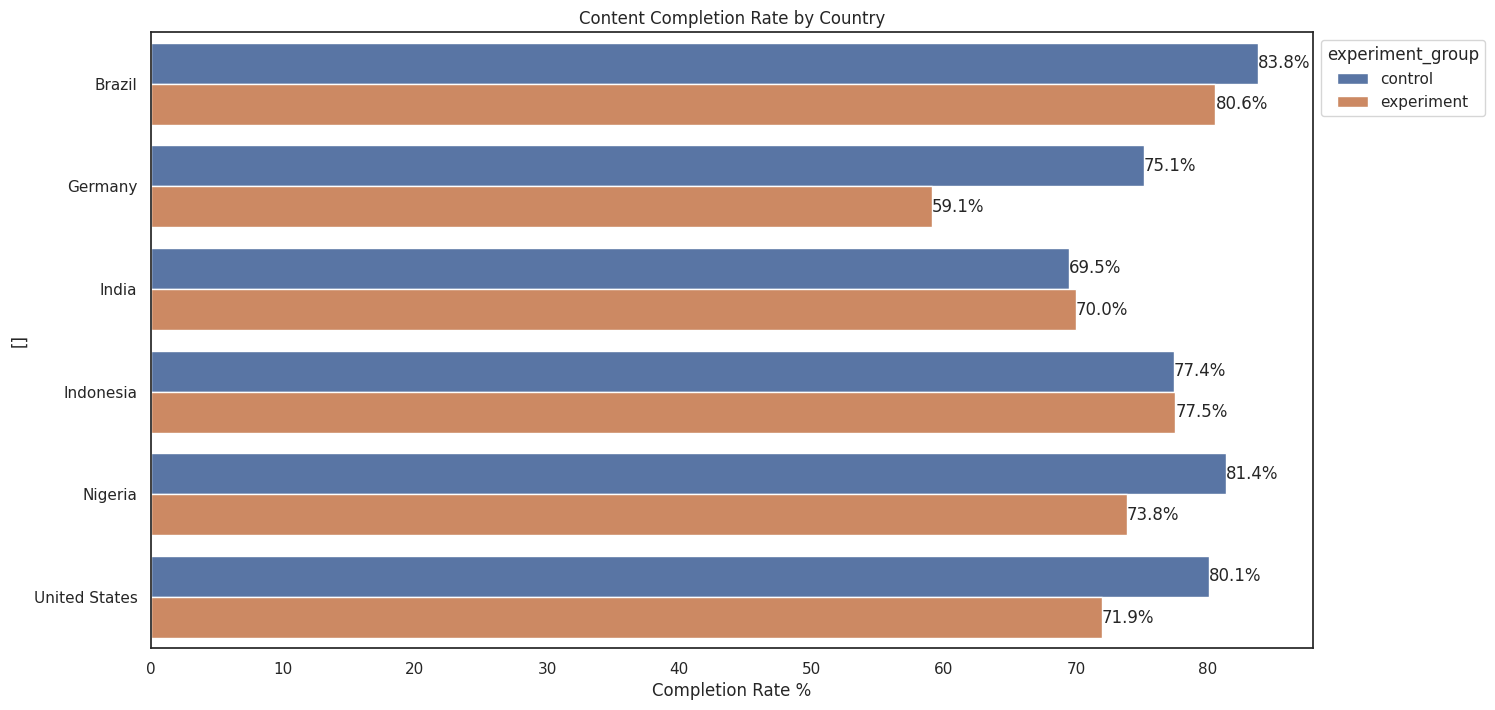

In [94]:
sns.set(rc={'figure.figsize':(15,8)})
sns.set_style("white")

ax= sns.barplot(content_completion_c, x="completion_rate", y="user_country", hue="experiment_group", orient="y")
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%')

plt.xlabel("Completion Rate %")
plt.ylabel([])  
plt.title('Content Completion Rate by Country')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


:::{.callout-note appearance=simple icon=false}

The content completion rate in **experiment groups** is lower in every country except **India and Indonesia**.

:::

## Top Viewed Content <a id="top_content_c"></a>

In [45]:
top_page_query_c = """

    SELECT 
        user_country AS Country,
        experiment_group AS ExperimentGroup,
        page_name AS Page, 
        COUNT(1) AS Pageview,
        SUM(CASE WHEN page_bottom_was_visible THEN 1 ELSE 0 END)/ COUNT(1) AS CompletionRate
    FROM global_temp.event_data_view
    WHERE event_type = 'pageUnloaded'
      AND topic != 'homepage'
    GROUP BY experiment_group, user_country, page_name

"""


In [46]:
top_page_c = spark.run(top_page_query_c)

### In control group

Top 10 viewed articles in **Brazil** are:

In [47]:
top_page_c.loc[(top_page_c['ExperimentGroup'] == 'control')&(top_page_c['Country'] == 'Brazil')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup               Page  Pageview  CompletionRate
29   Brazil         control      Amazon parrot         9        1.000000
135  Brazil         control           Baseball         7        0.857143
59   Brazil         control      Ancient Egypt         7        0.714286
82   Brazil         control            Friends         7        1.000000
337  Brazil         control              Japan         7        0.714286
2    Brazil         control       Lionel Messi         6        1.000000
115  Brazil         control            Obesity         6        1.000000
293  Brazil         control  Australian Magpie         5        0.400000
10   Brazil         control  Statue of Liberty         5        0.800000
151  Brazil         control             Comics         5        0.800000

Top 10 viewed articles in **Germany** are:

In [49]:
top_page_c.loc[(top_page_c['ExperimentGroup'] == 'control')&(top_page_c['Country'] == 'Germany')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup               Page  Pageview  CompletionRate
299  Germany         control  Statue of Liberty        14        0.714286
308  Germany         control       Lionel Messi        13        0.923077
31   Germany         control      Body piercing        12        0.750000
44   Germany         control              Japan        12        0.750000
315  Germany         control    Michael Jackson        10        0.700000
157  Germany         control            Friends         9        0.777778
89   Germany         control           Elephant         9        0.666667
224  Germany         control          Ice dance         9        0.666667
296  Germany         control     Masrur Temples         9        1.000000
13   Germany         control      Ancient Egypt         8        0.625000

Top 10 viewed articles in **India** are:

In [50]:
top_page_c.loc[(top_page_c['ExperimentGroup'] == 'control')&(top_page_c['Country'] == 'India')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup               Page  Pageview  CompletionRate
343   India         control            Friends        12        0.833333
231   India         control     Climate change        10        0.700000
14    India         control       Lionel Messi        10        0.900000
217   India         control              Japan         9        0.666667
144   India         control               Yoga         9        0.555556
15    India         control         Hyderabad          9        0.777778
290   India         control      Ancient Egypt         8        0.750000
112   India         control  Maya civilization         7        1.000000
240   India         control           Baseball         7        0.428571
225   India         control             Comics         7        0.857143

Top 10 viewed articles in **Indonesia** are:

In [51]:
top_page_c.loc[(top_page_c['ExperimentGroup'] == 'control')&(top_page_c['Country'] == 'Indonesia')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup               Page  Pageview  CompletionRate
289  Indonesia         control              Japan        12        0.916667
121  Indonesia         control       Lionel Messi        10        1.000000
297  Indonesia         control             Comics         8        0.625000
126  Indonesia         control           Baseball         7        0.428571
86   Indonesia         control           Elephant         6        0.833333
323  Indonesia         control            Friends         5        1.000000
91   Indonesia         control  Maya civilization         5        0.600000
318  Indonesia         control  Statue of Liberty         5        0.800000
178  Indonesia         control           Feminism         5        0.800000
291  Indonesia         control           Winnipeg         5        0.600000

Top 10 viewed articles in **Nigeria** are:

In [52]:
top_page_c.loc[(top_page_c['ExperimentGroup'] == 'control')&(top_page_c['Country'] == 'Nigeria')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup                 Page  Pageview  CompletionRate
177  Nigeria         control         Lionel Messi        22        0.863636
1    Nigeria         control              Friends        18        0.722222
110  Nigeria         control             Feminism        16        0.812500
338  Nigeria         control       Nelson Mandela        14        0.785714
329  Nigeria         control        Body piercing        14        0.928571
204  Nigeria         control        Maraba Coffee        13        0.846154
39   Nigeria         control      Michael Jackson        11        0.909091
313  Nigeria         control              Obesity        11        0.818182
310  Nigeria         control         Maya Angelou        11        0.818182
249  Nigeria         control  Youth Olympic Games        11        0.818182

Top 10 viewed articles in **United States** are:

In [53]:
top_page_c.loc[(top_page_c['ExperimentGroup'] == 'control')&(top_page_c['Country'] == 'United States')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup               Page  Pageview  \
194  United States         control      Ancient Egypt        15   
33   United States         control  Australian Magpie        14   
123  United States         control       Lionel Messi        14   
317  United States         control           Baseball        13   
273  United States         control      Body piercing        12   
174  United States         control     Nelson Mandela        12   
53   United States         control           Elephant        11   
258  United States         control            Friends        11   
216  United States         control      Maraba Coffee        10   
320  United States         control       Maya Angelou        10   

     CompletionRate  
194        0.666667  
33         0.571429  
123        0.714286  
317        0.846154  
273        0.833333  
174        0.833333  
53         0.636364  
258        0.727273  
216        0.700000  
320        0.900000

### In experiment group:

Top 10 viewed highlights in **Brazil** are:

In [54]:
top_page_c.loc[(top_page_c['ExperimentGroup'] == 'experiment')&(top_page_c['Country'] == 'Brazil')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup                Page  Pageview  CompletionRate
294  Brazil      experiment        Lionel Messi        16        0.562500
334  Brazil      experiment          Hyderabad         15        0.933333
3    Brazil      experiment               Japan        13        0.769231
191  Brazil      experiment             Friends        12        0.916667
101  Brazil      experiment                Yoga        11        0.909091
120  Brazil      experiment        Maya Angelou        11        0.727273
114  Brazil      experiment              Comics        10        0.900000
52   Brazil      experiment           Ice dance         9        0.777778
71   Brazil      experiment  Sustainable energy         9        0.555556
83   Brazil      experiment   Statue of Liberty         9        0.666667

Top 10 viewed highlights in **Germany** are:

In [55]:
top_page_c.loc[(top_page_c['ExperimentGroup'] == 'experiment')&(top_page_c['Country'] == 'Germany')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup               Page  Pageview  CompletionRate
279  Germany      experiment            Obesity        17        0.588235
118  Germany      experiment           Elephant        16        0.437500
180  Germany      experiment       Lionel Messi        15        0.333333
158  Germany      experiment            Giraffe        14        0.642857
312  Germany      experiment     Climate change        14        0.857143
189  Germany      experiment              Japan        12        0.500000
319  Germany      experiment           Feminism        11        0.636364
298  Germany      experiment      Ancient Egypt        11        0.545455
278  Germany      experiment  Statue of Liberty        11        0.545455
324  Germany      experiment      Body piercing        10        0.800000

Top 10 viewed highlights in **India** are:

In [56]:
top_page_c.loc[(top_page_c['ExperimentGroup'] == 'experiment')&(top_page_c['Country'] == 'India')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup                Page  Pageview  CompletionRate
295   India      experiment            Elephant        25        0.600000
130   India      experiment  Sustainable energy        17        0.647059
235   India      experiment      Climate change        17        0.823529
5     India      experiment          Hyderabad         16        0.750000
286   India      experiment       Amazon parrot        15        0.800000
12    India      experiment               Japan        15        0.733333
133   India      experiment   Australian Magpie        15        0.533333
192   India      experiment                Yoga        15        0.733333
117   India      experiment              Comics        15        0.533333
134   India      experiment     Michael Jackson        13        0.692308

Top 10 viewed highlights in **Indonesia** are:

In [57]:
top_page_c.loc[(top_page_c['ExperimentGroup'] == 'experiment')&(top_page_c['Country'] == 'Indonesia')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup               Page  Pageview  CompletionRate
300  Indonesia      experiment              Japan        15        0.733333
77   Indonesia      experiment       Lionel Messi        10        0.600000
162  Indonesia      experiment     Climate change         7        0.857143
62   Indonesia      experiment             Rwanda         7        0.571429
212  Indonesia      experiment  Statue of Liberty         7        0.428571
241  Indonesia      experiment         Hyderabad          7        1.000000
275  Indonesia      experiment             Comics         6        0.666667
80   Indonesia      experiment           Winnipeg         6        0.500000
106  Indonesia      experiment      Amazon parrot         6        1.000000
42   Indonesia      experiment            Giraffe         6        0.833333

Top 10 viewed highlights in **Nigeria** are:

In [58]:
top_page_c.loc[(top_page_c['ExperimentGroup'] == 'experiment')&(top_page_c['Country'] == 'Nigeria')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup                 Page  Pageview  CompletionRate
223  Nigeria      experiment         Lionel Messi        28        0.714286
186  Nigeria      experiment       Climate change        25        0.680000
163  Nigeria      experiment              Friends        21        0.714286
282  Nigeria      experiment                 Yoga        20        0.650000
263  Nigeria      experiment   Sustainable energy        20        0.700000
85   Nigeria      experiment    Statue of Liberty        19        0.684211
265  Nigeria      experiment  Youth Olympic Games        18        0.722222
246  Nigeria      experiment              Obesity        18        0.833333
30   Nigeria      experiment        Ancient Egypt        17        0.529412
11   Nigeria      experiment               Comics        17        0.764706

Top 10 viewed highlights in **United States** are:

In [59]:
top_page_c.loc[(top_page_c['ExperimentGroup'] == 'experiment')&(top_page_c['Country'] == 'United States')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup             Page  Pageview  CompletionRate
262  United States      experiment     Lionel Messi        18        0.666667
26   United States      experiment    Body piercing        17        0.764706
102  United States      experiment         Elephant        17        0.823529
267  United States      experiment          Friends        16        0.687500
108  United States      experiment  Michael Jackson        15        0.800000
269  United States      experiment   Climate change        15        0.666667
200  United States      experiment          Obesity        14        0.928571
179  United States      experiment         Feminism        13        0.769231
196  United States      experiment            Japan        13        0.846154
322  United States      experiment           Comics        12        0.750000

## Top View Topics <a id="top_topic_c"></a>

In [64]:
top_topic_query_c = """

    SELECT 
        user_country AS Country,
        experiment_group AS ExperimentGroup,
        category_name AS Topic, 
        COUNT(1) AS Pageview,
        SUM(CASE WHEN page_bottom_was_visible THEN 1 ELSE 0 END)/ COUNT(1) AS CompletionRate
    FROM global_temp.event_data_view
    WHERE event_type = 'pageUnloaded'
      AND topic != 'homepage'
    GROUP BY experiment_group,user_country, category_name

"""

In [ ]:
top_topic_c = spark.run(top_topic_query_c)

### In control group

Top viewed topics in **Brazil** are:

In [66]:
top_topic_c.loc[(top_topic_c['ExperimentGroup'] == 'control')&(top_topic_c['Country'] == 'Brazil')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup          Topic  Pageview  CompletionRate
88  Brazil         control         NATURE        21        0.857143
13  Brazil         control        HISTORY        20        0.800000
18  Brazil         control          SPORT        18        0.777778
93  Brazil         control      LIFESTYLE        16        0.812500
17  Brazil         control         PLACES        15        0.800000
76  Brazil         control  PERSONALITIES        14        1.000000
87  Brazil         control        TOPICAL        13        0.846154

Top viewed topics in **Germany** are:

In [67]:
top_topic_c.loc[(top_topic_c['ExperimentGroup'] == 'control')&(top_topic_c['Country'] == 'Germany')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup          Topic  Pageview  CompletionRate
20  Germany         control        HISTORY        39        0.769231
26  Germany         control      LIFESTYLE        31        0.806452
8   Germany         control  PERSONALITIES        29        0.793103
40  Germany         control          SPORT        28        0.678571
84  Germany         control         PLACES        27        0.814815
67  Germany         control         NATURE        24        0.583333
29  Germany         control        TOPICAL        23        0.782609

Top viewed topics in **India** are:

In [68]:
top_topic_c.loc[(top_topic_c['ExperimentGroup'] == 'control')&(top_topic_c['Country'] == 'India')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup          Topic  Pageview  CompletionRate
23   India         control      LIFESTYLE        29        0.758621
55   India         control        TOPICAL        25        0.680000
37   India         control        HISTORY        24        0.791667
57   India         control          SPORT        23        0.434783
21   India         control         PLACES        18        0.722222
54   India         control  PERSONALITIES        18        0.833333
78   India         control         NATURE        17        0.647059

Top viewed topics in **Indonesia** are:

In [69]:
top_topic_c.loc[(top_topic_c['ExperimentGroup'] == 'control')&(top_topic_c['Country'] == 'Indonesia')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup          Topic  Pageview  CompletionRate
80  Indonesia         control         PLACES        20        0.800000
65  Indonesia         control  PERSONALITIES        19        0.789474
62  Indonesia         control      LIFESTYLE        18        0.777778
2   Indonesia         control         NATURE        16        0.812500
16  Indonesia         control        HISTORY        15        0.733333
85  Indonesia         control          SPORT        14        0.571429
36  Indonesia         control        TOPICAL        13        0.923077

Top viewed topics in **Nigeria** are:

In [70]:
top_topic_c.loc[(top_topic_c['ExperimentGroup'] == 'control')&(top_topic_c['Country'] == 'Nigeria')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup          Topic  Pageview  CompletionRate
47  Nigeria         control  PERSONALITIES        58        0.844828
64  Nigeria         control      LIFESTYLE        53        0.849057
90  Nigeria         control        TOPICAL        46        0.782609
89  Nigeria         control          SPORT        34        0.794118
72  Nigeria         control         PLACES        32        0.812500
11  Nigeria         control        HISTORY        29        0.827586
92  Nigeria         control         NATURE        27        0.740741

Top viewed topics in **United States** are:

In [71]:
top_topic_c.loc[(top_topic_c['ExperimentGroup'] == 'control')&(top_topic_c['Country'] == 'United States')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup          Topic  Pageview  CompletionRate
66  United States         control      LIFESTYLE        43        0.767442
69  United States         control  PERSONALITIES        43        0.813953
73  United States         control         NATURE        40        0.675000
42  United States         control        HISTORY        33        0.787879
31  United States         control        TOPICAL        29        0.965517
82  United States         control          SPORT        28        0.892857
60  United States         control         PLACES        25        0.760000

### In experiment group:

Top viewed topics in **Brazil** are:

In [72]:
top_topic_c.loc[(top_topic_c['ExperimentGroup'] == 'experiment')&(top_topic_c['Country'] == 'Brazil')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup          Topic  Pageview  CompletionRate
70  Brazil      experiment         PLACES        43        0.860465
24  Brazil      experiment  PERSONALITIES        40        0.700000
52  Brazil      experiment      LIFESTYLE        39        0.923077
30  Brazil      experiment        TOPICAL        34        0.735294
19  Brazil      experiment          SPORT        33        0.878788
27  Brazil      experiment         NATURE        32        0.750000
48  Brazil      experiment        HISTORY        31        0.774194

Top viewed topics in **Germany** are:

In [73]:
top_topic_c.loc[(top_topic_c['ExperimentGroup'] == 'experiment')&(top_topic_c['Country'] == 'Germany')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup          Topic  Pageview  CompletionRate
45  Germany      experiment        TOPICAL        50        0.660000
81  Germany      experiment         NATURE        45        0.600000
95  Germany      experiment        HISTORY        33        0.606061
68  Germany      experiment  PERSONALITIES        30        0.466667
75  Germany      experiment      LIFESTYLE        28        0.714286
12  Germany      experiment         PLACES        23        0.478261
74  Germany      experiment          SPORT        16        0.500000

Top viewed topics in **India** are:

In [74]:
top_topic_c.loc[(top_topic_c['ExperimentGroup'] == 'experiment')&(top_topic_c['Country'] == 'India')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup          Topic  Pageview  CompletionRate
15   India      experiment         NATURE        67        0.656716
1    India      experiment        TOPICAL        53        0.754717
41   India      experiment         PLACES        46        0.782609
86   India      experiment  PERSONALITIES        44        0.681818
34   India      experiment      LIFESTYLE        43        0.674419
71   India      experiment          SPORT        42        0.690476
53   India      experiment        HISTORY        25        0.640000

Top viewed topics in **Indonesia** are:

In [75]:
top_topic_c.loc[(top_topic_c['ExperimentGroup'] == 'experiment')&(top_topic_c['Country'] == 'Indonesia')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup          Topic  Pageview  CompletionRate
22  Indonesia      experiment         PLACES        35        0.714286
44  Indonesia      experiment  PERSONALITIES        19        0.684211
58  Indonesia      experiment      LIFESTYLE        19        0.736842
59  Indonesia      experiment         NATURE        19        0.842105
6   Indonesia      experiment        TOPICAL        17        0.941176
51  Indonesia      experiment          SPORT        15        0.933333
33  Indonesia      experiment        HISTORY        14        0.642857

Top viewed topics in **Nigeria** are:

In [76]:
top_topic_c.loc[(top_topic_c['ExperimentGroup'] == 'experiment')&(top_topic_c['Country'] == 'Nigeria')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup          Topic  Pageview  CompletionRate
35  Nigeria      experiment        TOPICAL        78        0.769231
43  Nigeria      experiment  PERSONALITIES        71        0.690141
79  Nigeria      experiment          SPORT        65        0.723077
63  Nigeria      experiment      LIFESTYLE        58        0.775862
39  Nigeria      experiment        HISTORY        53        0.641509
91  Nigeria      experiment         NATURE        45        0.888889
3   Nigeria      experiment         PLACES        39        0.692308

Top viewed topics in **United States** are:

In [77]:
top_topic_c.loc[(top_topic_c['ExperimentGroup'] == 'experiment')&(top_topic_c['Country'] == 'United States')].sort_values(by=['Pageview'], ascending=False).head(10)

Country ExperimentGroup          Topic  Pageview  CompletionRate
4   United States      experiment      LIFESTYLE        54        0.740741
25  United States      experiment        TOPICAL        54        0.814815
32  United States      experiment  PERSONALITIES        52        0.769231
28  United States      experiment         NATURE        45        0.733333
94  United States      experiment          SPORT        35        0.600000
50  United States      experiment        HISTORY        33        0.575758
77  United States      experiment         PLACES        30        0.700000

:::{.callout-note appearance=simple icon=false}

From the list, we can see the most popular topics are differ country by country.

We see that some content, such as Lionel Messi and Climate change, appears in the top-viewed lists of most countries. The rest of the top-viewed content differs from country to country.

:::
